In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc

# Perform the necessary imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage, dendrogram

In [107]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...
1,2016-03-31,2100,2016-04-01,1553,QA,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,MEDUR,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha..."
3,2016-03-25,1400,2016-04-01,2126,QA,C7,MEDMED,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...
4,2016-04-02,0730,2016-04-02,0752,QA,D5,SURMHN,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...


In [108]:
df['division'] = df['inc_unit'].str[:3]
df['care group'] = df['inc_unit'].str[3:6]
df = df.drop('inc_unit',axis=1)

In [109]:
df.columns = [column.replace('inc_organisation','site') for column in df.columns]
df.columns = [column.replace('inc_locactual','ward/dept/unit') for column in df.columns]
df.columns = [column.replace('inc_unit','division & care group') for column in df.columns]
df.columns = [column.replace('inc_specialty','specialty') for column in df.columns]
df.columns = [column.replace('inc_loctype','location type') for column in df.columns]
df.columns = [column.replace('inc_result','result') for column in df.columns]
df.columns = [column.replace('inc_severity','severity') for column in df.columns]
df.columns = [column.replace('inc_reportedby','reported by') for column in df.columns]
df.columns = [column.replace('show_other_contacts','other patients involved?') for column in df.columns]
df.columns = [column.replace('show_employee','other employees involved?') for column in df.columns]
df.columns = [column.replace('show_witness','any witnesses?') for column in df.columns]
df.columns = [column.replace('show_document','any documents attached?') for column in df.columns]
df.head()

,inc_dincident,inc_time,inc_dreported,inc_submittedtime,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group
0,2016-03-31,0800,2016-03-31,2025,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...,MED,MED
1,2016-03-31,2100,2016-04-01,1553,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED
2,2016-04-01,1957,2016-04-01,2002,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha...",MED,UR
3,2016-03-25,1400,2016-04-01,2126,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED
4,2016-04-02,0730,2016-04-02,0752,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN


In [110]:
df_category = df.select_dtypes('object')
df_category = df.drop(['inc_notes'],axis=1)
print(df_category.columns)

Index(['inc_dincident', 'inc_time', 'inc_dreported', 'inc_submittedtime',
       'site', 'ward/dept/unit', 'specialty', 'location type', 'result',
       'severity', 'other patients involved?', 'other employees involved?',
       'any witnesses?', 'any documents attached?', 'reported by', 'division',
       'care group'],
      dtype='object')


In [111]:
df['inc_time'] = df['inc_time'].str.replace(':','')
df['inc_submittedtime'] = df['inc_submittedtime'].str.replace(':','')

In [112]:
df['inc_year'] = df.inc_dincident.dt.year
df['inc_month'] = df.inc_dincident.dt.month
df['inc_day'] = df.inc_dincident.dt.day
df['inc_week'] = df.inc_dincident.dt.week
df['inc_weekday'] = df.inc_dincident.dt.weekday
df['inc_quarter'] = df.inc_dincident.dt.quarter
df['inc_hour'] = df['inc_time'].str[:2]
df['inc_minute'] = df['inc_time'].str[2:4]
df['inc_time_datetime'] = pd.to_datetime(df['inc_time'], format='%H%M')
df['inc_time_timedelta'] = pd.to_timedelta(df['inc_time_datetime']) + pd.Timedelta(days=25567)
df['inc_datetime'] = df['inc_dincident'] + df['inc_time_timedelta']
df['inc_date_delta'] = (df['inc_datetime'] - df['inc_datetime'].min())  / np.timedelta64(1,'D')
df['reported_year'] = df.inc_dreported.dt.year
df['reported_month'] = df.inc_dreported.dt.month
df['reported_day'] = df.inc_dreported.dt.day
df['reported_week'] = df.inc_dreported.dt.week
df['reported_weekday'] = df.inc_dreported.dt.weekday
df['reported_quarter'] = df.inc_dincident.dt.quarter
df['reported_hour'] = df['inc_submittedtime'].str[:2]
df['reported_minute'] = df['inc_submittedtime'].str[2:4]
df['reported_time_datetime'] = pd.to_datetime(df['inc_submittedtime'], format='%H%M')
df['reported_time_timedelta'] = pd.to_timedelta(df['reported_time_datetime']) + pd.Timedelta(days=25567)
df['reported_datetime'] = df['inc_dreported'] + df['reported_time_timedelta']
df['reported_date_delta'] = (df['reported_datetime'] - df['reported_datetime'].min())  / np.timedelta64(1,'D')
df['diff'] = df['reported_datetime'] - df['inc_datetime']
df['reported-incident'] = df['diff'] / np.timedelta64(1, 'D')
df = df.astype({'inc_hour':'int'})
df = df.astype({'inc_minute':'int'})
df = df.astype({'reported_hour':'int'})
df = df.astype({'reported_minute':'int'})
df = df.drop(['inc_dincident','inc_time','inc_dreported','inc_submittedtime','inc_time_datetime','inc_time_timedelta','inc_datetime','reported_time_datetime','reported_time_timedelta','reported_datetime','diff'],axis=1)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version


,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,...,reported_year,reported_month,reported_day,reported_week,reported_weekday,reported_quarter,reported_hour,reported_minute,reported_date_delta,reported-incident
0,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,...,2016,3,31,13,3,1,20,25,0.000000,0.517361
1,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,...,2016,4,1,13,4,1,15,53,0.811111,0.786806
2,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,...,2016,4,1,13,4,2,20,2,0.984028,0.003472
3,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,...,2016,4,1,13,4,1,21,26,1.042361,7.309722
4,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,...,2016,4,2,13,5,2,7,52,1.477083,0.015278


In [113]:
result_classes = [str(i) for i in df['result'].value_counts().index]
result_mapping = {'NMISS':0,'NOHARM':1,'HARM':2}
df_replaced = df.replace({'result': result_mapping})

severity_classes = [str(i) for i in df['severity'].value_counts().index]
severity_mapping = {'NMISS':0,'NONE':1,'LOW':2,'MODRTE':3,'SEVERE':4,'':None}
df_replaced = df_replaced.replace({'severity': severity_mapping})

binary_mapping = {'N':0,'Y':1}
df_replaced = df_replaced.replace({'other patients involved?': binary_mapping})
df_replaced = df_replaced.replace({'other employees involved?': binary_mapping})
df_replaced = df_replaced.replace({'any witnesses?': binary_mapping})
df_replaced = df_replaced.replace({'any documents attached?': binary_mapping})
df_replaced.head()

,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,...,reported_year,reported_month,reported_day,reported_week,reported_weekday,reported_quarter,reported_hour,reported_minute,reported_date_delta,reported-incident
0,QA,E6/7,RESP,WARD,1,1.0,NaN,0,0,0,...,2016,3,31,13,3,1,20,25,0.000000,0.517361
1,QA,C5,GENMED,WARD,2,2.0,NaN,1,1,1,...,2016,4,1,13,4,1,15,53,0.811111,0.786806
2,QA,EMERG,ED,AE,1,1.0,NaN,0,0,0,...,2016,4,1,13,4,2,20,2,0.984028,0.003472
3,QA,C7,CARDIO,WARD,1,1.0,NaN,1,0,0,...,2016,4,1,13,4,1,21,26,1.042361,7.309722
4,QA,D5,ORTHO,WARD,1,1.0,NaN,0,0,0,...,2016,4,2,13,5,2,7,52,1.477083,0.015278


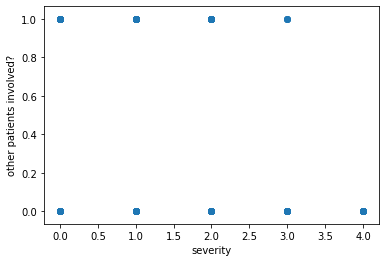

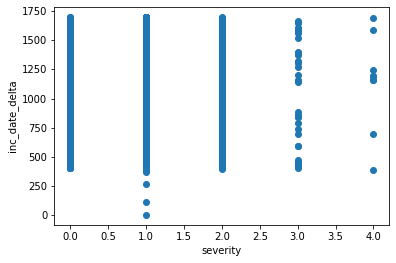

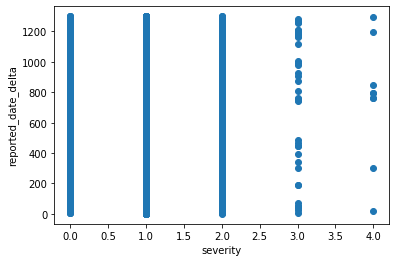

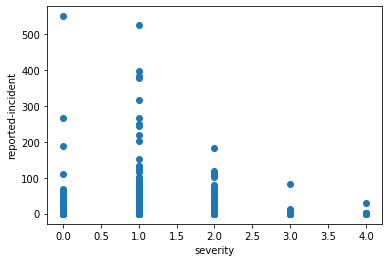

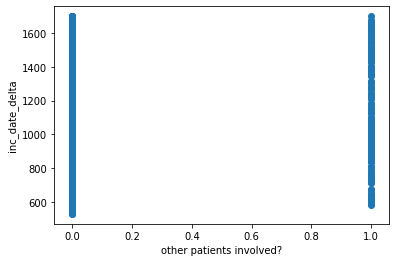

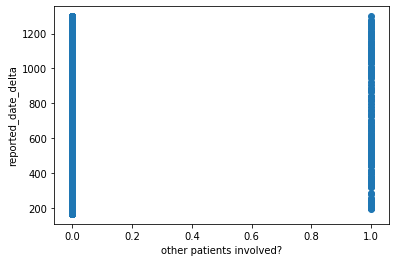

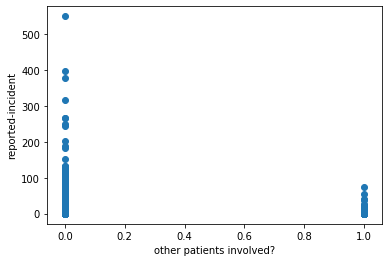

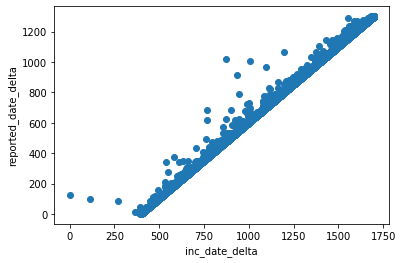

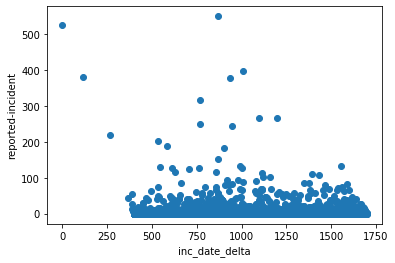

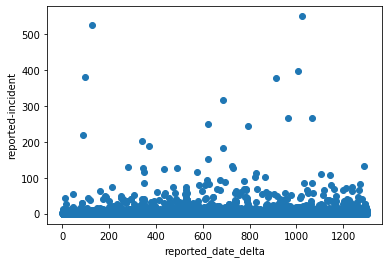

In [114]:
category_columns = list(df_replaced.select_dtypes('object'))
category_columns.remove('inc_notes')
num_columns = list(df_replaced.select_dtypes(exclude='object').columns.values)
int_columns = list(df_replaced.select_dtypes(['int64','int32']).columns.values)
float_columns = list(df_replaced.select_dtypes('float').columns.values)
for xi, column_x in enumerate(float_columns):
    for yi, column_y in enumerate(float_columns):
        if column_x!=column_y and yi>xi:
            df_dropped = df_replaced.dropna(subset=[column_x,column_y])
            xs = df_dropped[column_x]
            ys = df_dropped[column_y]
            plt.figure()
            plt.scatter(xs,ys);
            plt.xlabel(str(column_x))
            plt.ylabel(str(column_y))
#for xi, column_x in enumerate(int_columns):
#    df_dropped = df_replaced.dropna(subset=[column_x,'reported-incident'])
#    xs = df_dropped[column_x]
#    ys = df_dropped['reported-incident']
#    plt.figure()
#    plt.scatter(xs,ys);
#    plt.xlabel(str(column_x))
#    plt.ylabel('reported-incident')
#for xi, column_x in enumerate(num_columns):
#    for yi, column_y in enumerate(num_columns):
#        if column_x!=column_y and yi>xi:
#            df_dropped = df_replaced.dropna(subset=[column_x,column_y])
#            xs = df_dropped[column_x]
#            ys = df_dropped[column_y]
#            plt.figure()
#            plt.scatter(xs,ys);
#            plt.xlabel(str(column_x))
#            plt.ylabel(str(column_y))

In [115]:
# Create scaler: scaler
scaler = StandardScaler()
df_float = df_replaced.select_dtypes('float')
df_float = df_float.drop(['other patients involved?','severity'],axis=1)
scaler.fit(df_float)

samples_scaled = scaler.transform(df_float)
print(samples_scaled)

[[-1.91332023 -1.92117879 -0.14252958]
 [-1.91184566 -1.91896849 -0.12487473]
 [-1.90924247 -1.91849728 -0.17620122]
 ...
 [ 1.32990751  1.3240049  -0.17419912]
 [ 1.26744613  1.26686243 -0.04479084]
 [ 1.27277728  1.26688703 -0.17251554]]


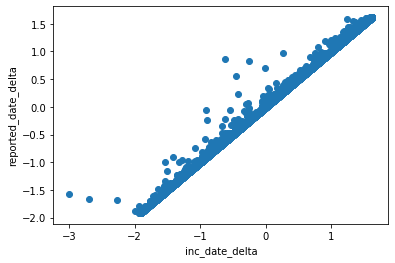

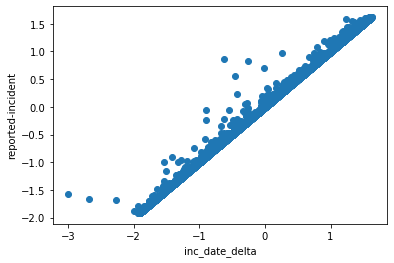

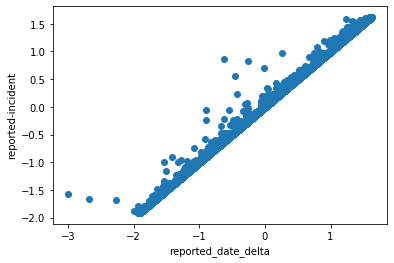

In [116]:
for xi, column_x in enumerate(df_float.columns.values):
    for yi, column_y in enumerate(df_float.columns.values):
        if column_x!=column_y and yi>xi:
            df_dropped = df_replaced.dropna(subset=[column_x,column_y])
            xs = samples_scaled[:,0]
            ys = samples_scaled[:,1]
            plt.figure()
            plt.scatter(xs,ys);
            plt.xlabel(str(column_x))
            plt.ylabel(str(column_y))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


MemoryError: unable to allocate array data.

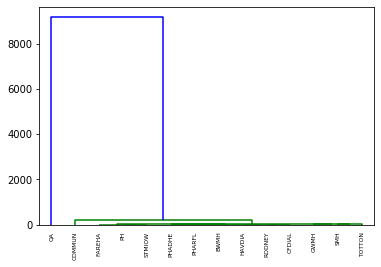

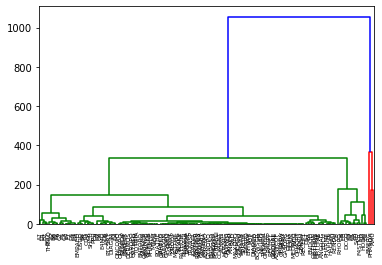

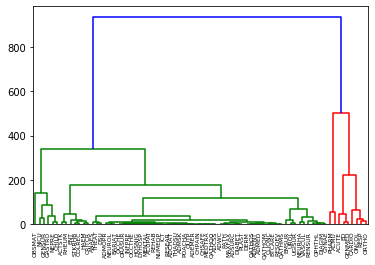

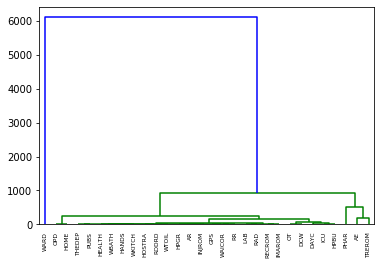

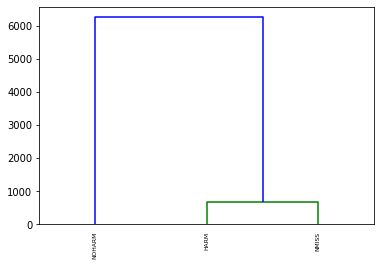

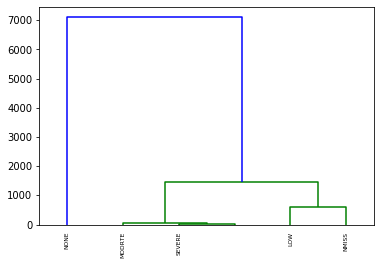

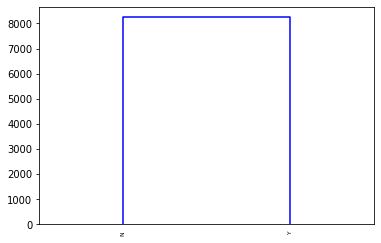

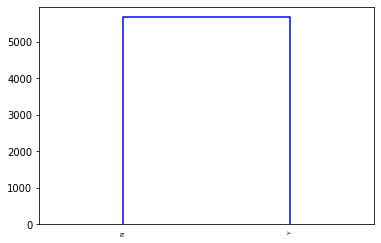

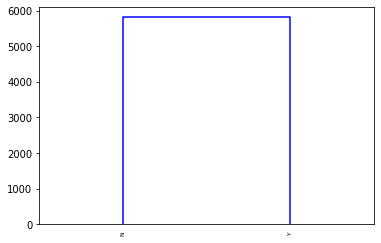

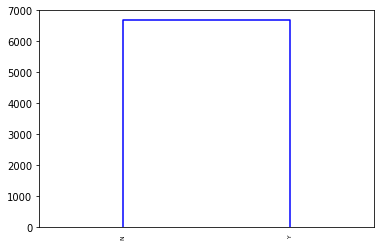

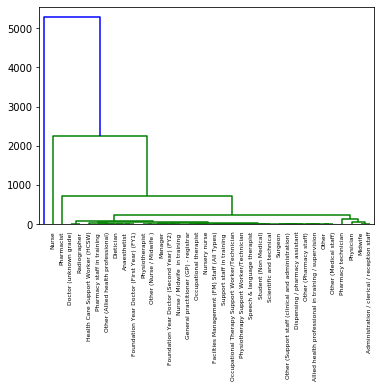

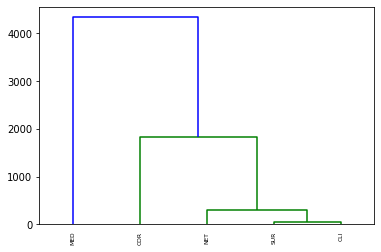

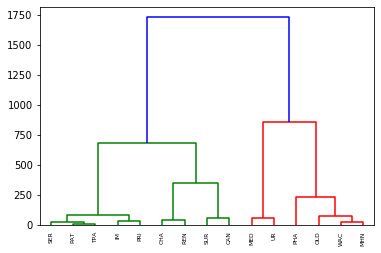

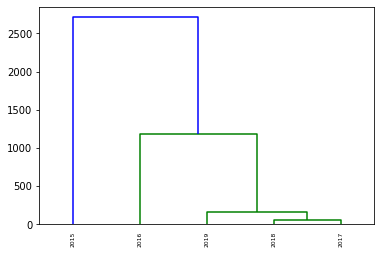

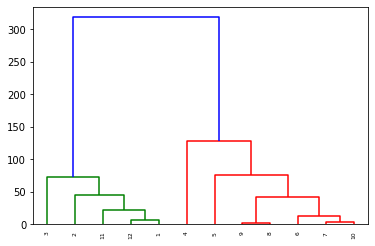

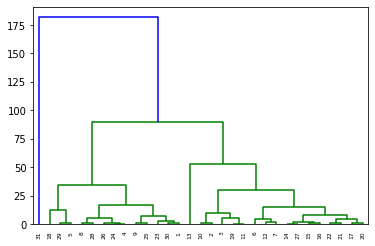

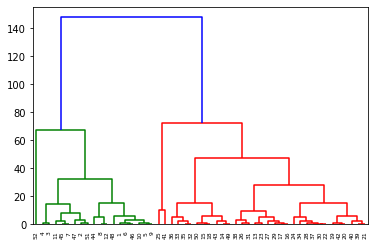

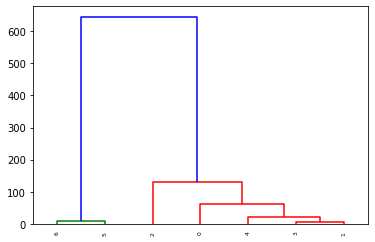

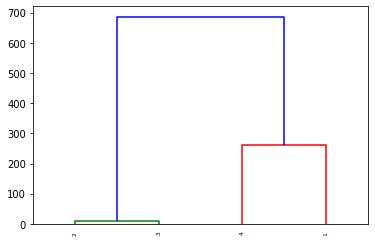

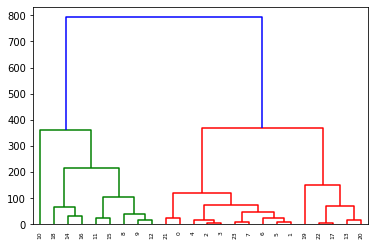

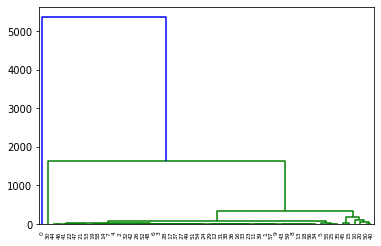

In [155]:
for column in df_category.columns:
    counts = df_category[column].value_counts()

    # Calculate the linkage: mergings
    mergings = linkage(np.reshape(counts.values, (len(counts.values),1)),method='complete')

    # Plot the dendrogram, using varieties as labels
    plt.figure()
    dendrogram(mergings,
               labels=list(counts.index),
               leaf_rotation=90,
               leaf_font_size=6,
    );